In [1]:
import anndata
import scanpy as sc
import pandas as pd
from scipy import sparse
from modules.process_data import *
from collections import Counter
from matplotlib.ticker import PercentFormatter
from modules.utils import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
from statsmodels.stats.multitest import multipletests
import re
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-07 07:46:28.409791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 07:46:29.110386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mapping = {'Multiplet': 'Multiplet',
           'SampleTag17_flex': 'WT-DMSO',
           'SampleTag18_flex': '3xTg-DMSO',
           'SampleTag19_flex': 'WT-SCDi',
           'SampleTag20_flex': '3xTg-SCDi',
           'Undetermined': 'Undetermined'}

In [3]:
#load sc data
adata = anndata.read_h5ad("data/fede_count.h5ad")

In [4]:
#data cleaning
adata = rm_high_mt(adata, threshold=0.6)
adata = filter_cells_by_gene_counts(adata)

In [5]:
#adata = rm_low_exp(adata, threshold=0.01)
#sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True, max_fraction=0.2)

In [6]:
sample_tags = pd.DataFrame(adata.obs.Sample_Tag)
sample_tags.index = sample_tags.index.astype('int64')
sample_tags = pd.DataFrame(sample_tags['Sample_Tag'].map(mapping))
sc_df = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, index=adata.obs_names, columns=adata.var_names)
sc_df.index = sc_df.index.astype('int64')
sc_df = sc_df.join(sample_tags)

In [7]:
#remove cell with sample tags "multiplet" or "undetermined"
sc_df = sc_df[~sc_df['Sample_Tag'].isin(['Multiplet', 'Undetermined'])]

In [8]:
adata1_df = sc_df[sc_df['Sample_Tag'] == 'WT-DMSO'].drop(['Sample_Tag'], axis=1)

In [9]:
adata2_df = sc_df[sc_df['Sample_Tag'] == '3xTg-DMSO'].drop(['Sample_Tag'], axis=1)

In [52]:
import pandas as pd
import scanpy as sc
from scipy.stats import ranksums
import numpy as np
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests

# Ensure that the indices and columns are strings
adata1_df.index = adata1_df.index.astype(str)
adata2_df.index = adata2_df.index.astype(str)
adata1_df.columns = adata1_df.columns.astype(str)
adata2_df.columns = adata2_df.columns.astype(str)

# Combine the data into a single DataFrame and ensure the data is float
count_data = pd.concat([adata1_df, adata2_df], axis=0).astype(float)

# Create a sample information DataFrame with condition labels
sample_info = pd.DataFrame({
    'condition': ['WT'] * adata1_df.shape[0] + ['TG'] * adata2_df.shape[0]
}, index=count_data.index)

# Ensure the sample_info index is a string
sample_info.index = sample_info.index.astype(str)

# Create an AnnData object with count data and sample information
adata = sc.AnnData(count_data.values, obs=sample_info)

# Set the variable names (gene names)
adata.var_names = count_data.columns.astype(str)

# Set the observation names (sample names)
adata.obs_names = count_data.index.astype(str)

# Store the raw data in the .raw attribute before transformation
adata.raw = adata.copy()

# Normalize and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Initialize lists to store the gene names, fold changes, and p-values
gene_names = []
log2_fold_changes = []
p_values = []

# Perform differential expression analysis gene by gene
for gene in tqdm(adata.var_names):
    # Extract expression values for the gene
    expr_values = adata[:, gene].X

    # Split expression values by condition
    expr_values_WT = expr_values[adata.obs['condition'] == 'WT']
    expr_values_TG = expr_values[adata.obs['condition'] == 'TG']

    # Perform Wilcoxon rank-sum test
    stat, p_value = ranksums(expr_values_WT, expr_values_TG)

    # Calculate mean expression values
    mean_WT = np.mean(expr_values_WT)
    mean_TG = np.mean(expr_values_TG)

    # Calculate log2 fold change
    if mean_WT > 0 and mean_TG > 0:
        log2_fold_change = np.log2(mean_TG / mean_WT)
    else:
        log2_fold_change = np.nan  # Handle cases where the mean is zero

    # Store the results
    gene_names.append(gene)
    log2_fold_changes.append(log2_fold_change)
    p_values.append(p_value)

# Convert p-values list to a NumPy array
p_values = np.array(p_values).reshape(-1)

# Perform Benjamini-Hochberg correction
_, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Calculate log10 of corrected p-values
log10_pvals_corrected = -np.log10(np.maximum(p_values_corrected, 1e-300))

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'gene': gene_names,
    'log2foldchange': log2_fold_changes,
    'pval': p_values,
    'pval_corrected': p_values_corrected,
    'log10pval_corrected': log10_pvals_corrected
})

100%|████████████████████████████████████| 28628/28628 [00:43<00:00, 655.94it/s]

                gene  log2foldchange      pval  pval_corrected  \
0      0610005C13Rik       -2.173617  0.947939        1.000000   
1      0610006L08Rik             NaN  0.944797        1.000000   
2      0610009B22Rik       -0.263801  0.505745        1.000000   
3      0610009E02Rik       -0.362628  0.839990        1.000000   
4      0610009L18Rik       -0.162949  0.749890        1.000000   
...              ...             ...       ...             ...   
28623         mt-Nd3        0.023426  0.000819        0.213100   
28624         mt-Nd4       -0.001390  0.107400        1.000000   
28625        mt-Nd4l        0.008158  0.189578        1.000000   
28626         mt-Nd5       -0.020489  0.002018        0.417733   
28627         mt-Nd6        0.051805  0.717211        1.000000   

       log10pval_corrected  
0                -0.000000  
1                -0.000000  
2                -0.000000  
3                -0.000000  
4                -0.000000  
...                    ...  
2862

In [180]:
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'gene': gene_names,
    'log2foldchange': log2_fold_changes,
    'pval': p_values,
    'pval_corrected': p_values_corrected,
    'log10pval_corrected': log10_pvals_corrected
})

In [129]:
# Assuming result_df is a pandas DataFrame with the necessary data
fold_change = results_df['log2foldchange']
p_value = results_df['pval']
log10_pvalue = results_df['log10pval_corrected']

In [130]:
# Define significant genes
significant = p_value < 0.05
non_significant = ~significant
significant_outside_range = significant & ((fold_change > 1) | (fold_change < -1))
significant_inside_range = significant & ((fold_change >= -1) & (fold_change <= 1))

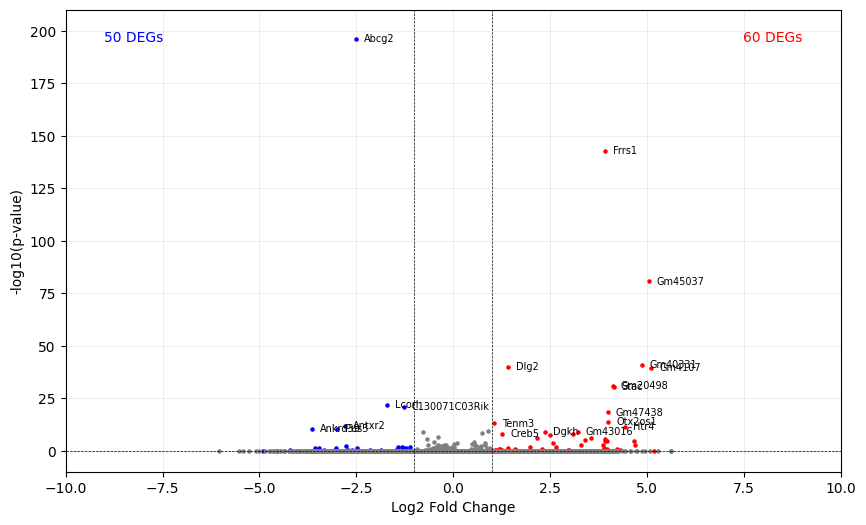

In [131]:


# Define significant genes
significant = p_value < 0.05
non_significant = ~significant
significant_outside_range = significant & ((fold_change > 1) | (fold_change < -1))
significant_inside_range = significant & ((fold_change >= -1) & (fold_change <= 1))

# Get the top 20 significant genes outside the range -1 to 1 for cleaner annotation
top_genes = results_df[significant_outside_range].nlargest(20, 'log10pval_corrected')
plt.figure(figsize=(10, 6))
# Create the volcano plot
plt.scatter(fold_change[significant_outside_range & (fold_change > 0)], log10_pvalue[significant_outside_range & (fold_change > 0)], s=5, c='red')
plt.scatter(fold_change[significant_outside_range & (fold_change <= 0)], log10_pvalue[significant_outside_range & (fold_change <= 0)], s=5, c='blue')
plt.scatter(fold_change[non_significant | significant_inside_range], log10_pvalue[non_significant | significant_inside_range], s=5, c='grey')

# Add dotted lines
plt.axvline(x=-1, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

# Annotate the top genes
for _, row in top_genes.iterrows():
    plt.annotate(row['gene'], (row['log2foldchange'] + 0.2, row['log10pval_corrected']), 
                 ha='left', va='center', fontsize=7)

# Count and annotate DEGs
positive_deg_num = (significant_outside_range & (fold_change > 0)).sum()
negative_deg_num = (significant_outside_range & (fold_change <= 0)).sum()

plt.annotate(f'{positive_deg_num} DEGs', xy=(9, 200), ha='right', va='top', fontsize=10, color='red')
plt.annotate(f'{negative_deg_num} DEGs', xy=(-9, 200), ha='left', va='top', fontsize=10, color='blue')
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray', alpha=0.2)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.xlim(-10, 10)
plt.ylim(-10, 210)

plt.savefig('volcano_plot.png')
plt.show()

In [133]:
positive_deg = results_df[(results_df["pval"] < 0.05) & (results_df["log2foldchange"] > 1)]['gene'].tolist()
positive_deg = [x.upper() for x in positive_deg]

negative_deg = results_df[(results_df["pval"] < 0.05) & (results_df["log2foldchange"] <= -1)]['gene'].tolist()
negative_deg = [x.upper() for x in negative_deg]

In [137]:
with open('positive_deg', 'w') as file:
    for gene in positive_deg:
        file.write(gene + '\n')

with open('negative_deg', 'w') as file:
    for gene in negative_deg:
        file.write(gene + '\n')

In [138]:
tsv_file_path = 'negative_go.txt'
df = pd.read_csv(tsv_file_path, delimiter='\t', skiprows=11)

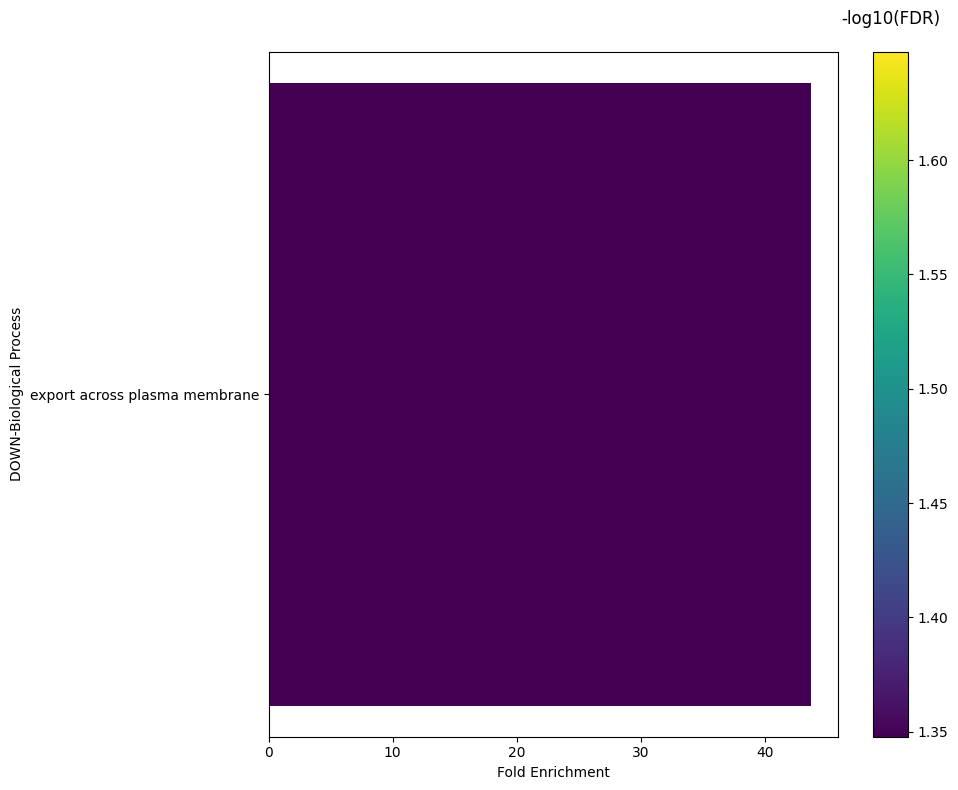

In [141]:
df['upload_1 (fold Enrichment)'] = pd.to_numeric(df['upload_1 (fold Enrichment)'], errors='coerce')
df['upload_1 (FDR)'] = pd.to_numeric(df['upload_1 (FDR)'], errors='coerce')

df = df.dropna(subset=['upload_1 (fold Enrichment)', 'upload_1 (FDR)'])

df = df[df['upload_1 (fold Enrichment)'] >= 1]

df['-log10(FDR)'] = -np.log10(df['upload_1 (FDR)'])

top_processes = df.nlargest(20, '-log10(FDR)')

top_processes['GO biological process complete'] = top_processes['GO biological process complete'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x))

top_processes = top_processes.sort_values(by='-log10(FDR)', ascending=False)

plt.figure(figsize=(10, 8))
norm = plt.Normalize(top_processes['-log10(FDR)'].min(), top_processes['-log10(FDR)'].max())
colors = plt.cm.viridis(norm(top_processes['-log10(FDR)']))
bars = plt.barh(top_processes['GO biological process complete'], top_processes['upload_1 (fold Enrichment)'], color=colors)

plt.xlabel('Fold Enrichment')
plt.ylabel('DOWN-Biological Process')
plt.gca().invert_yaxis()  # To display the highest -log10(FDR) at the top

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.ax.set_title('-log10(FDR)', pad=20)

plt.tight_layout()
plt.savefig('down_bio_process.png')
plt.show()


In [308]:
positive_deg = results_df[(results_df["pval"] < 0.05) & (results_df["log2foldchange"] > 1)]['gene'].tolist()
negative_deg = results_df[(results_df["pval"] < 0.05) & (results_df["log2foldchange"] <= -1)]['gene'].tolist()

adata1 = anndata.AnnData(X=adata1_df.values, obs=pd.DataFrame(index=adata1_df.index), var=pd.DataFrame(index=adata1_df.columns))
adata2 = anndata.AnnData(X=adata2_df.values, obs=pd.DataFrame(index=adata2_df.index), var=pd.DataFrame(index=adata2_df.columns))

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


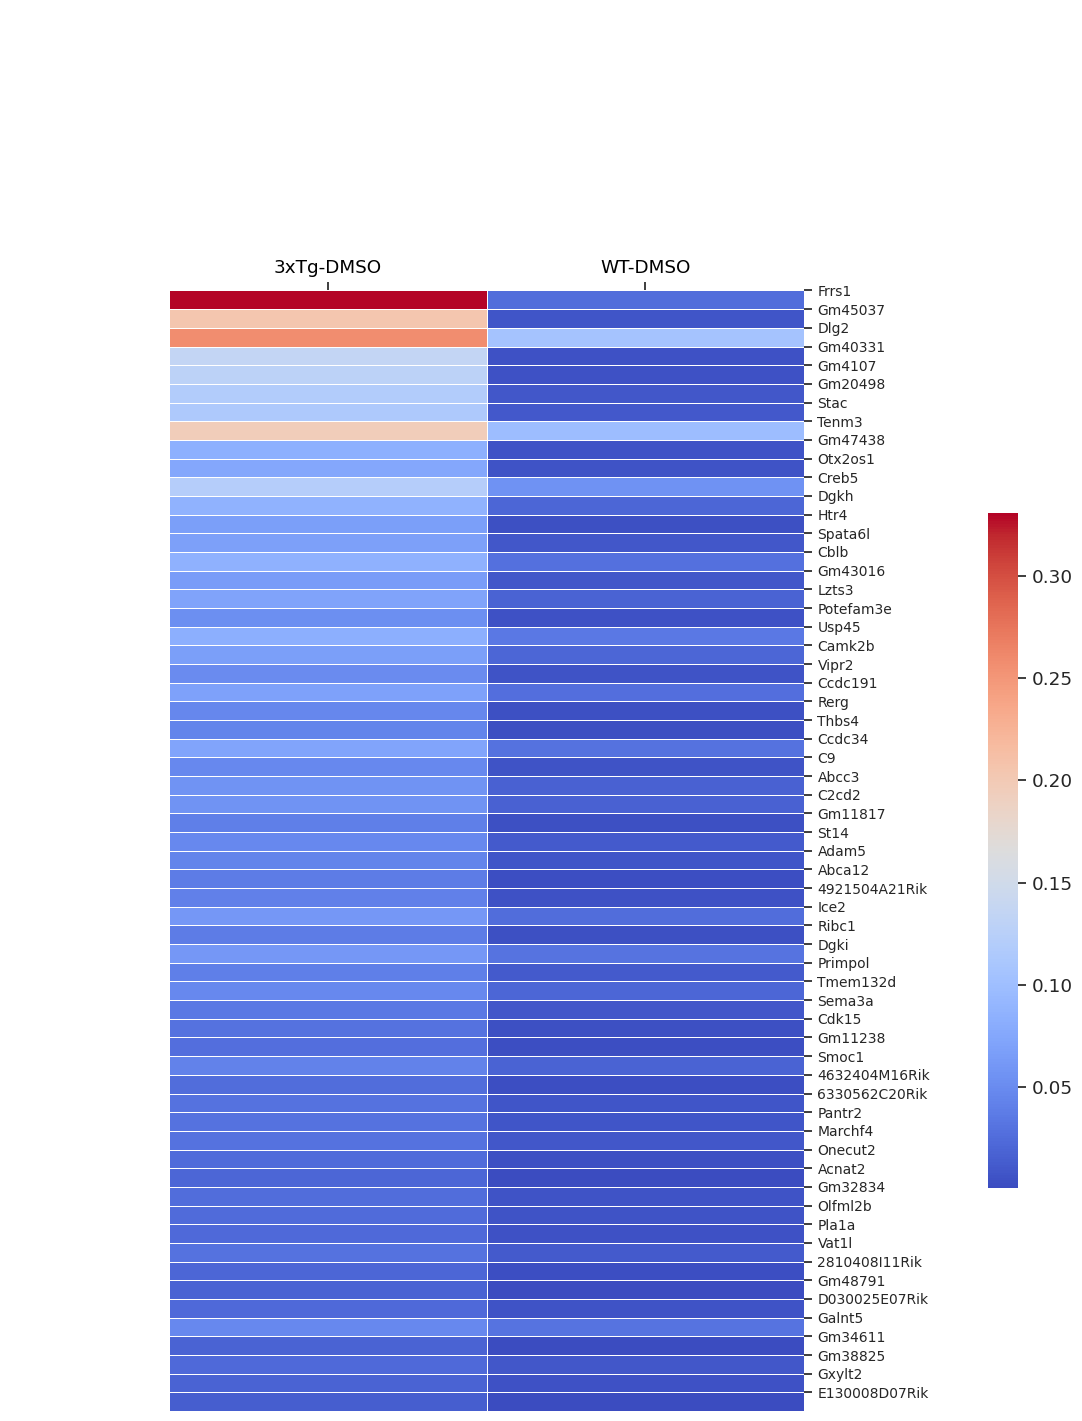

In [322]:
# Subset the data and set the batch labels
adata1_subset = adata1[:, positive_deg].copy()
adata2_subset = adata2[:, positive_deg].copy()
adata1_subset.obs['batch'], adata2_subset.obs['batch'] = 'WT-DMSO', '3xTg-DMSO'

# Normalize and log-transform the data
sc.pp.normalize_total(adata1_subset)
sc.pp.log1p(adata1_subset)
# sc.pp.scale(adata1_subset, max_value=1)

sc.pp.normalize_total(adata2_subset)
sc.pp.log1p(adata2_subset)
# sc.pp.scale(adata2_subset, max_value=1)

# Combine the datasets
combined_adata = anndata.concat([adata1_subset, adata2_subset])

# Calculate mean expression for each batch
mean_expr = combined_adata.to_df().groupby(combined_adata.obs['batch']).mean().T

# Calculate the difference in mean expression between the batches
mean_expr['diff'] = mean_expr['3xTg-DMSO'] - mean_expr['WT-DMSO']

# Calculate the absolute difference to the minimal difference
mean_expr['abs_diff_to_min'] = mean_expr['diff'].abs() - mean_expr['diff'].abs().min()

# Sort by the largest difference to the minimal difference
mean_expr_sorted = mean_expr.sort_values(by='abs_diff_to_min', ascending=False).drop(columns=['diff', 'abs_diff_to_min'])

# Set seaborn context and create the clustermap without the dendrogram
sns.set(context='notebook', font_scale=1.2)
cg = sns.clustermap(mean_expr_sorted, cmap='coolwarm', linewidths=.5, figsize=(10, 15), row_cluster=False, col_cluster=False)

# Display gene names on the heatmap with a specific font size on the right side
cg.ax_heatmap.set_yticks(range(len(mean_expr_sorted.index)))
cg.ax_heatmap.set_yticklabels(mean_expr_sorted.index, rotation=0, fontsize=10)
cg.ax_heatmap.yaxis.set_label_position('right')
cg.ax_heatmap.yaxis.tick_right()

# Adjust colorbar and axis labels
cg.cax.set_position([1, .2, .03, .45])
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel('')
for tick in cg.ax_heatmap.get_xticklabels():
    tick.set_color('black')
    tick.set_ha('center')
    tick.set_rotation(0)

# Adjust layout and save the figure with the colorbar included
plt.savefig('positive_heatmap.png', bbox_inches='tight')
plt.show()

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


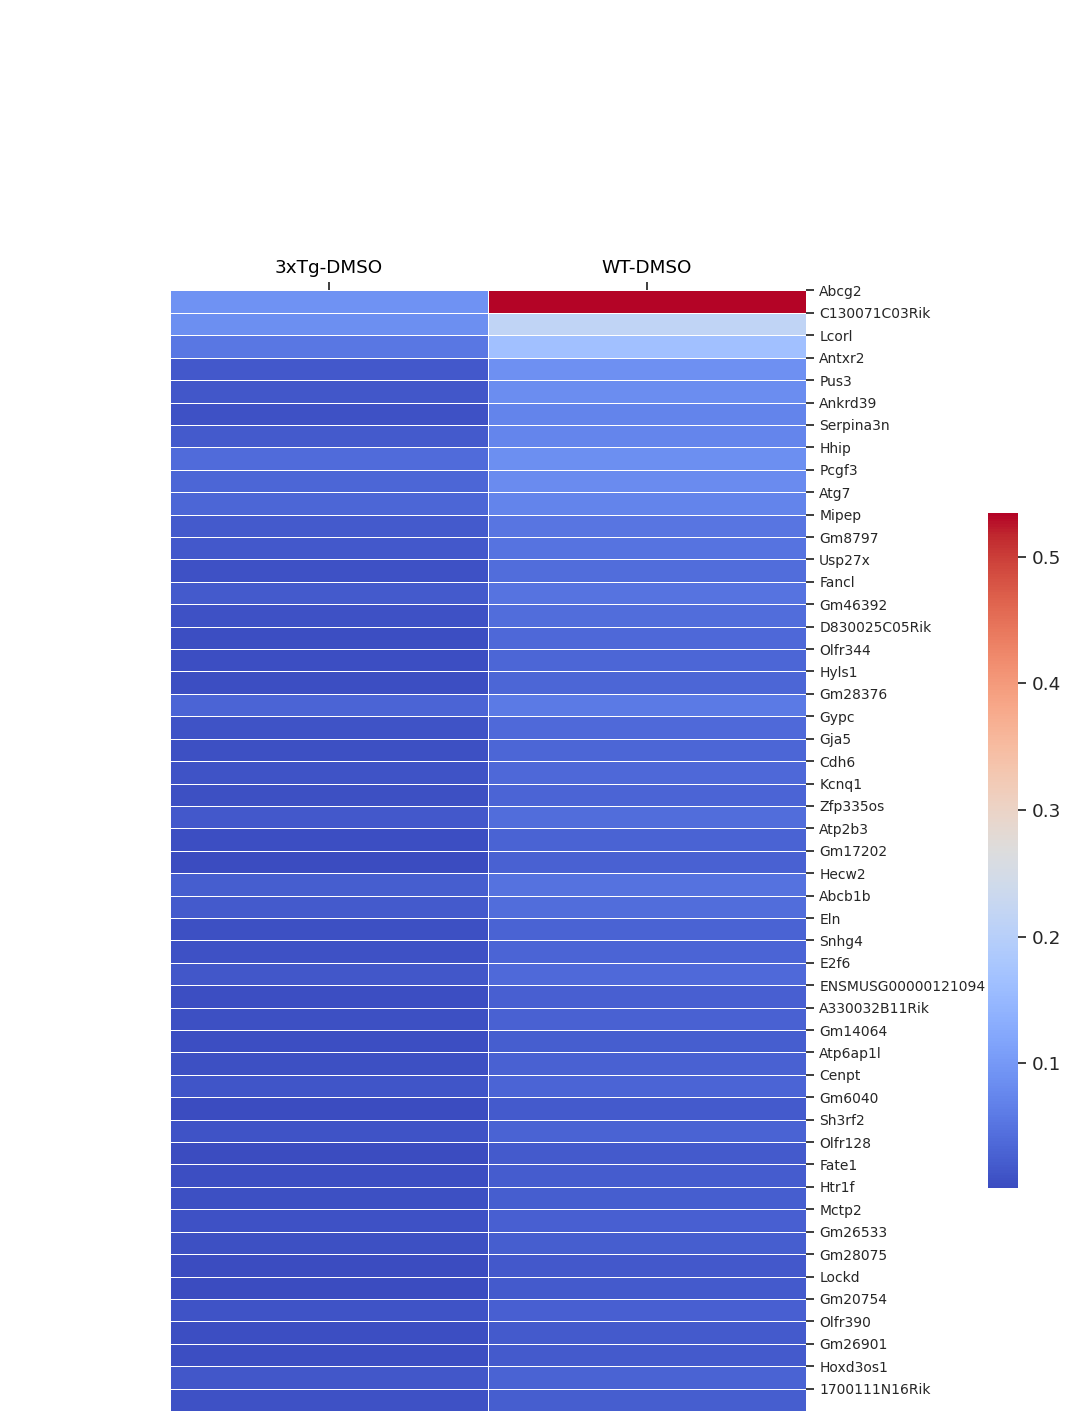

In [323]:
import scanpy as sc
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the data and set the batch labels
adata1_subset = adata1[:, negative_deg].copy()
adata2_subset = adata2[:, negative_deg].copy()
adata1_subset.obs['batch'], adata2_subset.obs['batch'] = 'WT-DMSO', '3xTg-DMSO'

# Normalize and log-transform the data
sc.pp.normalize_total(adata1_subset)
sc.pp.log1p(adata1_subset)
# sc.pp.scale(adata1_subset, max_value=1)

sc.pp.normalize_total(adata2_subset)
sc.pp.log1p(adata2_subset)
# sc.pp.scale(adata2_subset, max_value=1)

# Combine the datasets
combined_adata = anndata.concat([adata1_subset, adata2_subset])

# Calculate mean expression for each batch
mean_expr = combined_adata.to_df().groupby(combined_adata.obs['batch']).mean().T

# Calculate the difference in mean expression between the batches
mean_expr['diff'] = mean_expr['3xTg-DMSO'] - mean_expr['WT-DMSO']

# Calculate the absolute difference to the minimal difference
mean_expr['abs_diff_to_min'] = mean_expr['diff'].abs() - mean_expr['diff'].abs().min()

# Sort by the largest difference to the minimal difference
mean_expr_sorted = mean_expr.sort_values(by='abs_diff_to_min', ascending=False).drop(columns=['diff', 'abs_diff_to_min'])

# Set seaborn context and create the clustermap without the dendrogram
sns.set(context='notebook', font_scale=1.2)
cg = sns.clustermap(mean_expr_sorted, cmap='coolwarm', linewidths=.5, figsize=(10, 15), row_cluster=False, col_cluster=False)

# Display gene names on the heatmap with a specific font size on the right side
cg.ax_heatmap.set_yticks(range(len(mean_expr_sorted.index)))
cg.ax_heatmap.set_yticklabels(mean_expr_sorted.index, rotation=0, fontsize=10)
cg.ax_heatmap.yaxis.set_label_position('right')
cg.ax_heatmap.yaxis.tick_right()

# Adjust colorbar and axis labels
cg.cax.set_position([1, .2, .03, .45])
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel('')
for tick in cg.ax_heatmap.get_xticklabels():
    tick.set_color('black')
    tick.set_ha('center')
    tick.set_rotation(0)

# Adjust layout and save the figure with the colorbar included
plt.savefig('negative_heatmap.png', bbox_inches='tight')
plt.show()
